# Lab 4.1  Mann-Kendall Trend Test

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
from scipy.io import loadmat
import matplotlib.pyplot as plt

Load data.

In [2]:
snow_pillows = pd.read_csv('pillows_example.csv')
BLC_max = snow_pillows['BLC_max']
SLI_max = snow_pillows['SLI_max']

Plot the data

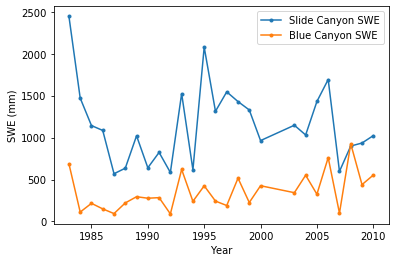

In [3]:
f, ax = plt.subplots()
ax.plot(snow_pillows['years'],SLI_max,'.-',label='Slide Canyon SWE')
ax.plot(snow_pillows['years'],BLC_max,'.-',label='Blue Canyon SWE')
plt.legend()
ax.set_xlabel('Year')
ax.set_ylabel('SWE (mm)');

# Mann Kendall Test

In [4]:
def mann_kendall(V,alpha):
    '''Mann Kendall Test (adapted from original Matlab function)
       Performs original Mann-Kendall test of the null hypothesis of trend absence in the vector V,  
       against the alternative of trend.
       The result of the test is returned in H = False indicates a rejection of the null hypothesis at 
       the alpha significance level. 
       H = True indicates a failure to reject the null hypothesis at the alpha significance level.
       
       INPUTS:
       V = time series [vector]
       alpha =  significance level of the test [scalar] (i.e. for 95% confidence, alpha=0.05)
       OUTPUTS:
       H = test result [1] Reject of Null Hypthesis [0] Insufficient evidence to reject the null hypothesis
       p_value = p-value of the test
       
       From Original Matlab Help Documentation:
       The significance level of a test is a threshold of probability a agreed
       to before the test is conducted. A typical value of alpha is 0.05. If the p-value of a test is less than alpha,
       the test rejects the null hypothesis. If the p-value is greater than alpha, there is insufficient evidence 
       to reject the null hypothesis. 
       The p-value of a test is the probability, under the null hypothesis, of obtaining a value
       of the test statistic as extreme or more extreme than the value computed from
       the sample.
       
       References 
       Mann, H. B. (1945), Nonparametric tests against trend, Econometrica, 13, 245-259.
       Kendall, M. G. (1975), Rank Correlation Methods, Griffin, London.
       
       Original written by Simone Fatichi - simonef@dicea.unifi.it
       Copyright 2009
       $Date: 2009/10/03 $
       modified: E.I. (1/12/2012)
       modified for python: Steven Pestana - spestana@uw.edu (10/17/2019)
       '''
    
    V = np.reshape(V, len(V), 1)
    alpha = alpha/2
    n = len(V)
    S = 0

    for i in range(0, n-1):
        for j in range(i+1, n):
            if V[j]>V[i]:
                S = S+1
            if V[j]<V[i]:
                S = S-1

    VarS = (n*(n-1)*(2*n+5))/18
    StdS = np.sqrt(VarS)
    # Ties are not considered

    # Kendall tau correction coefficient
    Kendall_Tau = S/(n*(n-1)/2)
    if S>=0:
        if S==0:
             Z = 0
        else:
            Z = ((S-1)/StdS)
    else:
        Z = (S+1)/StdS

    Zalpha = st.norm.ppf(1-alpha,0,1)
    p_value = 2*(1-st.norm.cdf(abs(Z), 0, 1)) #Two-tailed test p-value

    H = abs(Z) > Zalpha
    
    return H, p_value

#### Run the Man Kendall tests:

In [5]:
alpha = 0.05

H, p_value = mann_kendall(SLI_max,alpha)
print('Can we reject the null hypothesis for Slide Canyon?\n{}\n'.format(H))

H, p_value = mann_kendall(BLC_max,alpha)
print('Can we reject the null hypothesis for Blue Canyon?\n{}\n'.format(H))

Can we reject the null hypothesis for Slide Canyon?
False

Can we reject the null hypothesis for Blue Canyon?
True

